# How to prepare the source galaxy from an image

In [1]:
import os
import sys
import PIL
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from lenstronomy.Util import image_util
from MuSLIT.utils.plot import nice_colorbar

In [2]:
num_pix_final = 100
pad_pecentage = 120
offset_x_percentage = 20
offset_y_percentage = 15

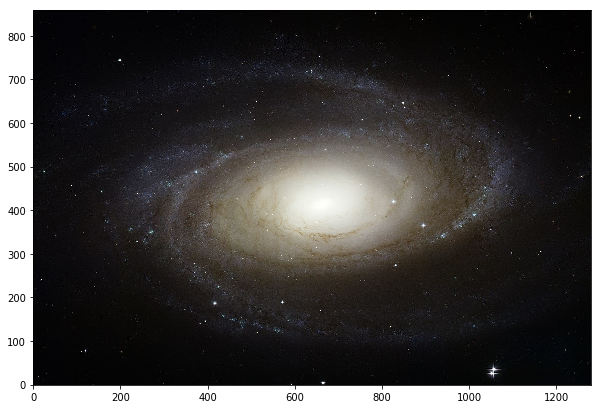

In [3]:
# read data and convert to lunminance
galaxy_image = PIL.Image.open('../Data/various_images/M81_HST.png')

plt.figure(figsize=(10, 10))
plt.imshow(galaxy_image, origin='lower')
plt.show()

In [4]:
galaxy_rgb = np.array(galaxy_image.convert('RGB'), dtype=float)
print(galaxy_rgb.shape)

galaxy_gray = np.array(galaxy_image.convert('L'), dtype=float)
print(galaxy_gray.shape)

(860, 1280, 3)
(860, 1280)


In [5]:
def prepare_one_layer(galaxy_single_layer, num_pix, normalize=True):
    # crop a few pixels to remove bright stars
    galaxy_init = galaxy_single_layer[50:, :]
    # subtract the median of an edge of the image
    median = np.median(galaxy_init[:50, :50])
    galaxy_init -= median
    if normalize:
        # normalize so the max is 1
        galaxy_init /= galaxy_init.max()

    # resize the image to square size (add zeros at the edges of the non-square bits of the image)
    nx, ny = np.shape(galaxy_init)
    n_max = max(nx, ny)
    galaxy_square = np.zeros((n_max, n_max))
    x_start = int((n_max - nx)/2.)
    y_start = int((n_max - ny)/2.)
    galaxy_square[x_start:x_start+nx, y_start:y_start+ny] = galaxy_init

    # pad it to make it look smaller on its plane + decentralize it
    num_pad = int(n_max * pad_pecentage/100)
    offset_x = int(n_max * offset_x_percentage/100)
    offset_y = int(n_max * offset_y_percentage/100)
    paddings = ((num_pad+offset_x, num_pad-offset_x), (num_pad+offset_y, num_pad-offset_y))
    galaxy_square = np.pad(galaxy_square, paddings, mode='constant', constant_values=((0, 0), (0, 0)))

    # we slightly convolve the image with a Gaussian convolution kernel of a few pixels (optional)
    #import scipy.ndimage.filters as scifilter
    #sigma = 1
    #galaxy_square = scifilter.gaussian_filter(galaxy_square, sigma, mode='nearest', truncate=6)

    # we now degrate the pixel resoluton by a factor
    factor = int(len(galaxy_square)/num_pix)
    num_half_cut = int((len(galaxy_square) - num_pix*factor) / 2)
    galaxy_cut = galaxy_square[num_half_cut:-num_half_cut, num_half_cut:-num_half_cut]

    galaxy_final = image_util.re_size(galaxy_cut, factor)  # re-size image to lower resolution
    return galaxy_final

In [6]:
galaxy_final = prepare_one_layer(galaxy_gray, num_pix_final)
print(galaxy_final.shape)

(100, 100)


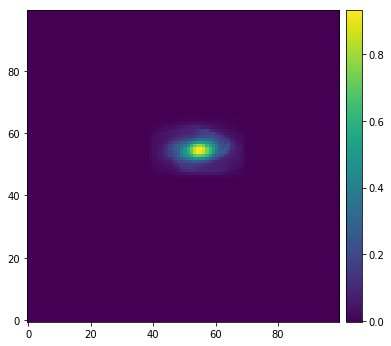

In [7]:
plt.figure(figsize=(6, 6))
im = plt.imshow(galaxy_final, origin='lower')
nice_colorbar(im, size='5%')
plt.show()

In [8]:
fits_path = '../Data/various_images/M81_HST_prepared_n{}.fits'.format(num_pix_final)

hdu = pyfits.PrimaryHDU(galaxy_final)
hdu.writeto(fits_path, overwrite=True)
print("Kappa map successfully saved to", fits_path)

Kappa map successfully saved to ../Data/various_images/M81_HST_prepared_n100.fits
